<h1>Submitted by : Shreyash Poudel , CS-21, ASSIGNMENT NO : 5 </h1>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import warnings
import logging

# Disable TensorFlow v2 behavior to use v1-style code
tf.disable_v2_behavior()





Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# reading the data from the data/btc.csv 
df = pd.read_csv("data/btc.csv")
df.head(5)


,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [3]:

# Get closing price of bitcoins
data = df["Close"].values

data


array([7520.  , 7459.11, 7584.15, ...,  378.  ,  378.  ,  370.  ])

In [4]:
# Standardizing the data
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

Text(0, 0.5, 'Price')

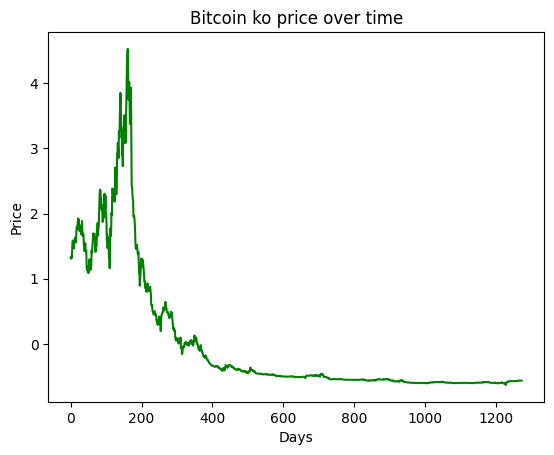

In [5]:
plt.title('Bitcoin ko price over time')
plt.plot(data, c="g")
plt.xlabel('Days')
plt.ylabel('Price')


In [6]:
# function to get data according to window size
def get_data(data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i = i + 1 
    assert len(X) == len(y)
    return X, y

# consider window size 7 and get data
X, y = get_data(data, window_size = 7)

In [7]:
#train (first 1000 points)

X_train = np.array(X[:1000])
y_train = np.array(y[:1000])
#test split 
X_test= np.array(X[1000:])
y_test = np.array(y[1000:])

X_train.shape

(1000, 7, 1)

In [8]:
#  defining hyperparameters
batch_size = 7
window_size = 7
hidden_layer = 256
learning_rate = 0.001


In [9]:
# placeholders for input and output
input = tf.placeholder(tf.float32, [batch_size, window_size, 1])
target = tf.placeholder(tf.float32, [batch_size, 1])


In [10]:
# defining weights to use in LSTM cell

# weights for input gate
U_i = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_i = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_i = tf.Variable(tf.zeros([hidden_layer]))

# weights for forget gate
U_f = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_f = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_f = tf.Variable(tf.zeros([hidden_layer]))

# weights for output gate
U_o = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.Variable(tf.zeros([hidden_layer]))

# weights for candidate state
U_g = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.Variable(tf.zeros([hidden_layer]))

# weights for output layer
V = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.Variable(tf.zeros([1]))


In [11]:
# defininign the LSTM Cell

def LSTM_cell(input, prev_hidden_state, prev_cell_state):
    it = tf.sigmoid(tf.matmul(input, U_i) + tf.matmul(prev_hidden_state, W_i) + b_i)
    ft = tf.sigmoid(tf.matmul(input, U_f) + tf.matmul(prev_hidden_state, W_f) + b_f)
    ot = tf.sigmoid(tf.matmul(input, U_o) + tf.matmul(prev_hidden_state, W_o) + b_o)
    gt = tf.tanh(tf.matmul(input, U_g) + tf.matmul(prev_hidden_state, W_g) + b_g)
    ct = (prev_cell_state * ft) + (it * gt)
    ht = ot * tf.tanh(ct)
    return ct, ht

In [12]:

# define forward propagratiun

y_hat = []
for i in range(batch_size):
    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32)
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(tf.reshape(input[i][t], (-1, 1)), hidden_state, cell_state)
    y_hat.append(tf.matmul(hidden_state, V) + b_v)

In [13]:
# define back propagration
losses = []

for i in range(len(y_hat)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(target[i], (-1, 1)), y_hat[i]))
loss = tf.reduce_mean(losses)

# gradient clipping to avoid exploding gradient problem
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

# use adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients, tf.trainable_variables()))


In [14]:
# training LSTM for 1000 iteratoin

session = tf.Session()
session.run(tf.global_variables_initializer())

epochs =  100

for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []
    while(index + batch_size) <= len(X_train):
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})
        epoch_loss.append(loss_val)
        train_predictions.append(predicted)
        index += batch_size
    if (i % 10)== 0:
        print(f"Epoch {i}, Loss: {np.mean(epoch_loss)}")

Epoch 0, Loss: 0.1972496211528778
Epoch 10, Loss: 0.04785190522670746
Epoch 20, Loss: 0.029110105708241463
Epoch 30, Loss: 0.018987987190485
Epoch 40, Loss: 0.016560379415750504
Epoch 50, Loss: 0.011786248534917831
Epoch 60, Loss: 0.010050690732896328
Epoch 70, Loss: 0.010416384786367416
Epoch 80, Loss: 0.008825591765344143
Epoch 90, Loss: 0.007889308966696262


In [15]:
# making predictions using LSTM
predicted_output = []
i = 0

while i+batch_size <= len(X_test):
    output = session.run([y_hat],feed_dict={input:X_test[i:i+batch_size]})
    i += batch_size
    predicted_output.append(output)
    
predicted_output[0]

[[array([[-0.6036612]], dtype=float32),
  array([[-0.6014818]], dtype=float32),
  array([[-0.600371]], dtype=float32),
  array([[-0.59931654]], dtype=float32),
  array([[-0.5987138]], dtype=float32),
  array([[-0.60006845]], dtype=float32),
  array([[-0.59689677]], dtype=float32)]]

In [16]:
# flatten test predictions
predicted_values_test = []
for i in range(len(predicted_output)):
    for j in range(len(predicted_output[i][0])):
        predicted_values_test.append(predicted_output[i][0][j])

predicted_values_test[0]


array([[-0.6036612]], dtype=float32)

In [17]:
predicted_values_test = [x for x in predicted_values_test]

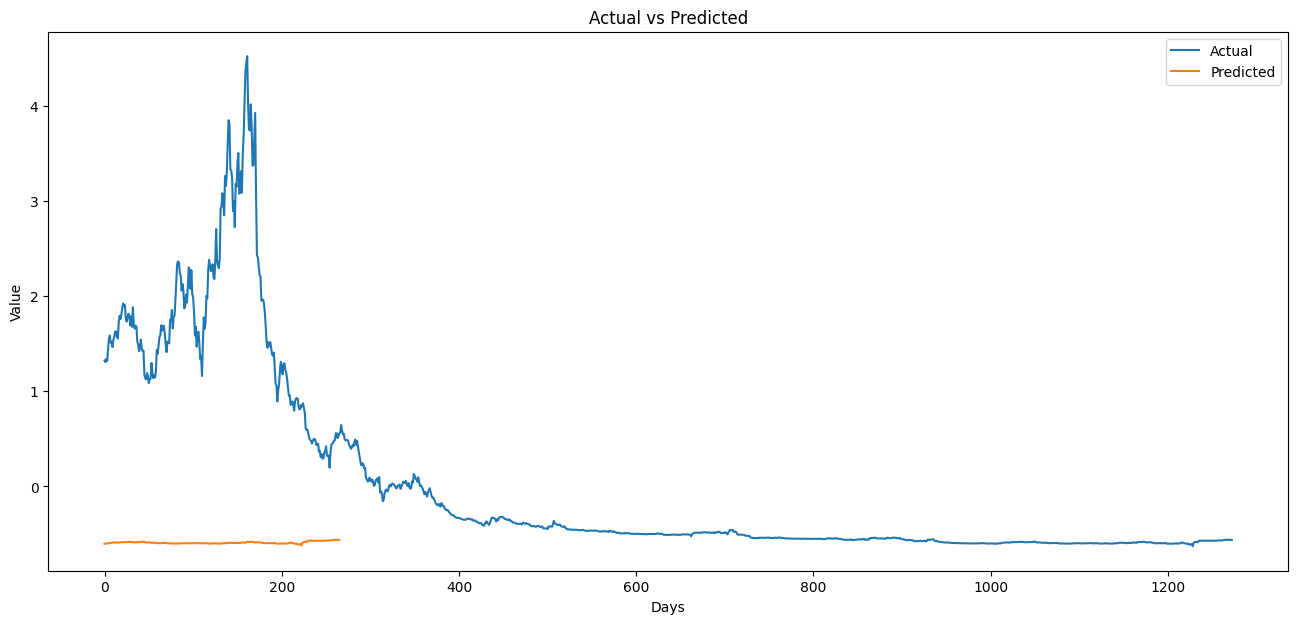

In [18]:
# Converting list to NumPy array, then flatten
predicted_values_test = np.array(predicted_values_test).reshape(-1)

# Now ploting the graph
plt.figure(figsize=(16, 7))
plt.plot(data, label='Actual')
plt.plot(predicted_values_test, label='Predicted')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.show()

Implementing Gru cell in tensor flow


In [19]:

# Parameters
vocab_size = 10
hidden_size = 8
sequence_length = 5
batch_size = 1


In [20]:

inputs = np.random.randint(0, vocab_size, size=(batch_size, sequence_length))

# Build graph
graph = tf.Graph()
with graph.as_default():
    # Placeholders
    X = tf.placeholder(tf.int32, [batch_size, sequence_length], name="X")
    
    # One-hot encode input
    X_onehot = tf.one_hot(X, depth=vocab_size)

    # Weights
    init = tf.keras.initializers.glorot_uniform()

    Uz = tf.get_variable("Uz", [vocab_size, hidden_size], initializer=init)
    Wz = tf.get_variable("Wz", [hidden_size, hidden_size], initializer=init)
    bz = tf.get_variable("bz", [hidden_size], initializer=tf.zeros_initializer())

    Ur = tf.get_variable("Ur", [vocab_size, hidden_size], initializer=init)
    Wr = tf.get_variable("Wr", [hidden_size, hidden_size], initializer=init)
    br = tf.get_variable("br", [hidden_size], initializer=tf.zeros_initializer())

    Uc = tf.get_variable("Uc", [vocab_size, hidden_size], initializer=init)
    Wc = tf.get_variable("Wc", [hidden_size, hidden_size], initializer=init)
    bc = tf.get_variable("bc", [hidden_size], initializer=tf.zeros_initializer())

    V = tf.get_variable("V", [hidden_size, vocab_size], initializer=init)
    by = tf.get_variable("by", [vocab_size], initializer=tf.zeros_initializer())

    h_t = tf.zeros([batch_size, hidden_size])
    outputs = []

    for t in range(sequence_length):
        x_t = X_onehot[:, t, :]  # shape: [batch_size, vocab_size]
        zt = tf.sigmoid(tf.matmul(x_t, Uz) + tf.matmul(h_t, Wz) + bz)
        rt = tf.sigmoid(tf.matmul(x_t, Ur) + tf.matmul(h_t, Wr) + br)
        ct = tf.tanh(tf.matmul(x_t, Uc) + tf.matmul(rt * h_t, Wc) + bc)
        h_t = (1 - zt) * ct + zt * h_t
        y_hat_t = tf.matmul(h_t, V) + by
        outputs.append(y_hat_t)

    outputs_stacked = tf.stack(outputs, axis=1)  


In [21]:

# Run session
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(outputs_stacked, feed_dict={X: inputs})

print("Input:", inputs)
print("Output shape:", result.shape)


Input: [[3 9 5 9 4]]
Output shape: (1, 5, 10)
